**1. Import Libraries/Dataset**

In [1]:
# Import Libraries

import os
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.utils import shuffle 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import cv2   
import random

In [2]:
random.seed(42)         # Initialize the random number generator.
np.random.seed(42)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(42)  # sets the graph-level random seed

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
SPLIT_PCT = 0.9          #defining split percent
VAL_SPLIT = 0.05         #defining the validation percent
SHUFFLE_SPLIT = True     #if want to shuffle the data
IMG_SIZE = (150, 150)    #image_size
BS = 8
IMAGE_SIZE = (150, 150)

In [20]:
!cp '/content/drive/MyDrive/imagenette2-160.tar' '/content/sample_data/'

In [5]:
training_dir = '/content/imagenette2-160/train/'
test_dir = '/content/imagenette2-160/val/'

In [6]:
os.listdir(training_dir)

['n03417042',
 'n02979186',
 'n03888257',
 'n03394916',
 'n03000684',
 'n03445777',
 'n02102040',
 'n01440764',
 'n03028079',
 'n03425413']

In [7]:
#list of class_names as mentioned on the dataset link ['golf ball', 'church', 'cassette player', 'chain saw', 'French horn', 'gas pump', 'parachute', 'tench', 'English springer', 'garbage truck']
#each folder corresponds to above classes and each folder is encoded to categories accordingly in above order

class_label = ['golf ball', 'church', 'cassette player', 'chain saw', 'French horn', 'gas pump', 'parachute', 'tench', 'English springer', 'garbage truck']
class_names = {'n03445777':0, 'n03028079':1, 'n02979186':2,'n03000684': 3, 'n03394916':4,'n03425413': 5, 'n03888257':6, 'n01440764':7, 'n02102040':8, 'n03417042':9}

nb_classes = len(class_names)

im_shape = (150, 150)
BATCH_SIZE = 16

In [8]:
class_names

{'n01440764': 7,
 'n02102040': 8,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 1,
 'n03394916': 4,
 'n03417042': 9,
 'n03425413': 5,
 'n03445777': 0,
 'n03888257': 6}

**2. Data Visualization and augmentation**

*Bring the train and test data in the required format.*

In [9]:
def load_data():
    
    
    datasets = [training_dir,test_dir]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        for folder in os.listdir(dataset):
            label = class_names[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
        try:        
          images = np.array(images, dtype = 'float32')
          labels = np.array(labels, dtype = 'int32')   
          output.append((images, labels))
        except:
          pass
    
    return output

In [10]:
(train_images, train_labels),(test_images, test_labels) = load_data()

  4%|▍         | 37/961 [00:00<00:02, 369.28it/s]

Loading /content/imagenette2-160/train/


 32%|███▏      | 126/389 [00:00<00:00, 1257.09it/s]

Loading /content/imagenette2-160/val/


100%|██████████| 419/419 [00:00<00:00, 1256.92it/s]


In [52]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [61]:
test_images, test_labels = shuffle(test_images, test_labels, random_state=25)

*Print the shapes of train and test data*




In [13]:
print(train_labels.shape)
print(train_images.shape)

(9469,)
(9469, 150, 150, 3)


In [14]:
print(test_labels.shape)
print(test_images.shape)

(3925,)
(3925, 150, 150, 3)


In [15]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 9469
Number of testing examples: 3925
Each image is of size: (150, 150)


In [16]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

*Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).*

In [17]:
def display_examples(class_names, images, labels):
    """
        Display 2 images from each folder (2*10) in form the images array
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

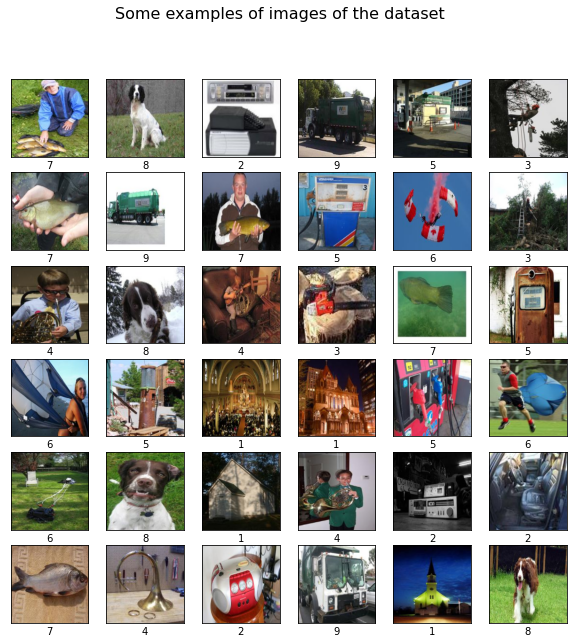

In [18]:
display_examples(class_names, train_images, train_labels)

*Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print theaugmented image and the original image for each class and each augmentation*

In [19]:
data_generator = ImageDataGenerator(
        rotation_range=50,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255)

train_generator = data_generator.flow_from_directory(training_dir, target_size=im_shape, shuffle=True, seed=20,
                                                     class_mode='categorical', batch_size=60, subset="training")
nb_train_samples = train_generator.samples

Found 9469 images belonging to 10 classes.


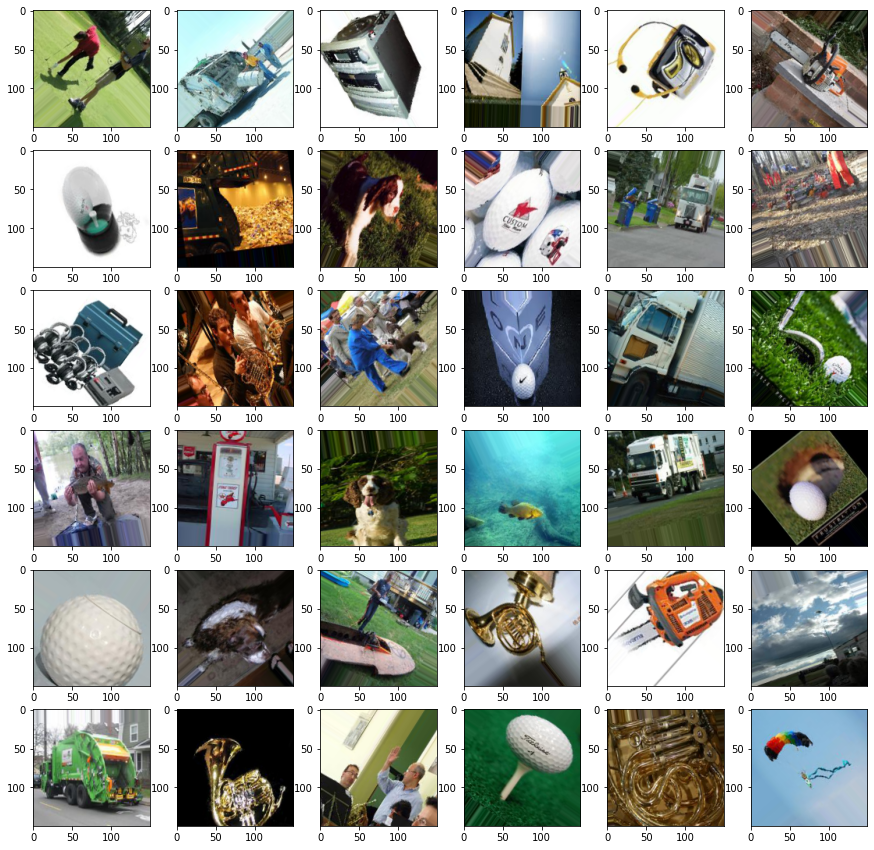

In [20]:
# Visualizing some classes
plt.figure(figsize=(15,15))
for i in range(36):
    #gera subfigures
    plt.subplot(6,6,i+1)
   
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()


**3.Model Building**

*Sequential Model layers-Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons. Add L2 regularization to all the layers.*

- Hidden units choosen as 60, 50, 30 since our input image size is 150,150 and size on units should not be more than twice of input, higher hidden units were making the model more complex to had chosen above numbers of hidden nodes

*Add L2 regularization to all the layers*

*Add one layer of dropout at the appropriate position and give reasons*

- Added Droput layer just before the last hidden layer because they are the one with the greater number of units and thus they're likely to excessively co-adapting themselves causing overfitting

*Choose the appropriate activation function for all the layers.*

- We have used relu, in all the hidden layers because rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

*Print the model summary.*

In [21]:
model = models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150, 150, 50)      200       
_________________________________________________________________
flatten (Flatten)            (None, 1125000)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                67500060  
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
Total params: 67,502,400
Trainable params: 67,502,400
Non-trainable params: 0
____________________________________________

**4. Model Compilation**

*Compile the model with the appropriate loss function.*

*Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.*

- We have used SGD, as it gives better results in generalizing the model and it converges well on flat or asymmetric valleys.

Learning rate chosen 0.001, so that model is able to learn and understand the data well, with lesser learning rate , the model was giving poor results

*Use accuracy as a metric.*

In [22]:
model.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

**5. Model Training**

*Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.*

In [23]:
history = model.fit(train_images, train_labels, batch_size=80, epochs=72, validation_split = 0.25)

Epoch 1/72
89/89 [==============================] - 11s 93ms/step - loss: 2.5184 - accuracy: 0.1067 - val_loss: 2.4419 - val_accuracy: 0.1554
Epoch 2/72
89/89 [==============================] - 8s 86ms/step - loss: 2.4376 - accuracy: 0.1367 - val_loss: 2.4178 - val_accuracy: 0.1432
Epoch 3/72
89/89 [==============================] - 8s 86ms/step - loss: 2.4187 - accuracy: 0.1341 - val_loss: 2.4055 - val_accuracy: 0.1706
Epoch 4/72
89/89 [==============================] - 8s 86ms/step - loss: 2.4138 - accuracy: 0.1467 - val_loss: 2.3973 - val_accuracy: 0.1875
Epoch 5/72
89/89 [==============================] - 8s 87ms/step - loss: 2.3965 - accuracy: 0.1593 - val_loss: 2.3896 - val_accuracy: 0.2065
Epoch 6/72
89/89 [==============================] - 8s 86ms/step - loss: 2.3823 - accuracy: 0.1669 - val_loss: 2.3637 - val_accuracy: 0.2221
Epoch 7/72
89/89 [==============================] - 8s 86ms/step - loss: 2.3637 - accuracy: 0.1866 - val_loss: 2.3542 - val_accuracy: 0.2386
Epoch 8/72
8

*Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.*

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

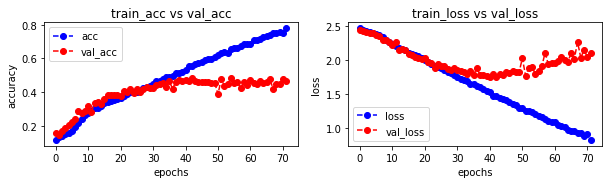

In [26]:
plot_accuracy_loss(history)

**6. Model Evaluation**

*Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset.*

In [27]:
test_loss = model.evaluate(test_images, test_labels)

print(test_loss)

123/123 [==============================] - 2s 18ms/step - loss: 2.0797 - accuracy: 0.4622
[2.0796830654144287, 0.46216559410095215]


In [28]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + str(labels[index]))
    plt.show()

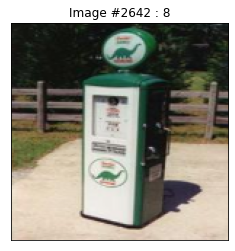

              precision    recall  f1-score   support

           0       0.62      0.30      0.40       399
           1       0.48      0.52      0.50       409
           2       0.41      0.58      0.48       357
           3       0.28      0.24      0.26       386
           4       0.32      0.46      0.38       394
           5       0.38      0.24      0.29       419
           6       0.69      0.63      0.66       390
           7       0.63      0.62      0.63       387
           8       0.43      0.49      0.46       395
           9       0.52      0.56      0.54       389

    accuracy                           0.46      3925
   macro avg       0.47      0.46      0.46      3925
weighted avg       0.48      0.46      0.46      3925

Time taken to predict the model 1.5993120670318604


In [29]:
from sklearn.metrics import classification_report
import time

start_time = time.time()

predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels)

print(classification_report(test_labels, pred_labels))
print("Time taken to predict the model " + str(time.time() - start_time))

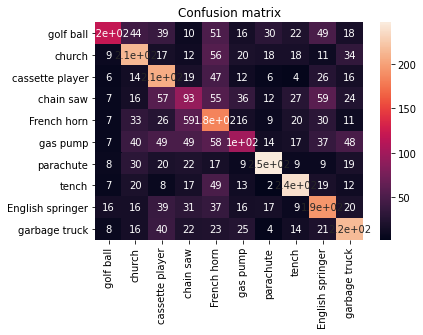

In [30]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_label, 
           yticklabels=class_label, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

*Analyse and report the best and worst performing class.*

In [31]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 20 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names, mislabeled_images, mislabeled_labels)

*Print the two most incorrectly classified images for each class in the test dataset.* *italicized text*

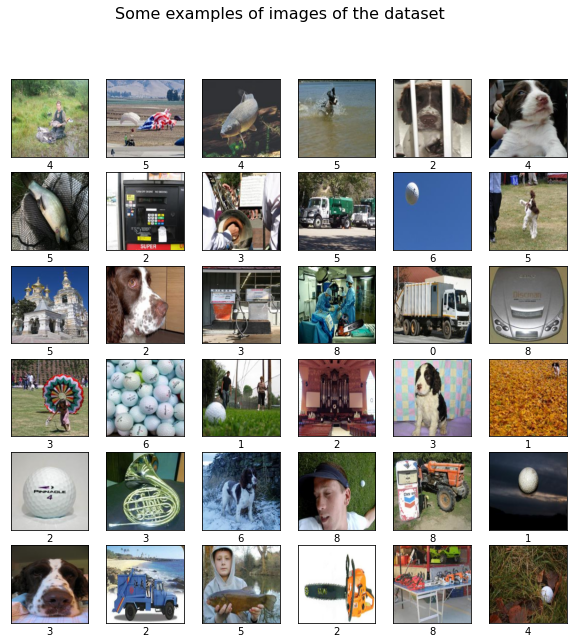

In [32]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

**Hyperparameter Tuning**

**Modified Model 1**

*Network Depth: Change the number of hidden layers and hidden units for each layer*

In [36]:
import gc
tf.keras.backend.clear_session()
gc.collect()

183

In [40]:
model = models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 150, 150, 50)      200       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1125000)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                72000064  
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 72,000,914
Trainable params: 72,000,914
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
 model.fit(train_images, train_labels, batch_size=80, epochs=72, validation_split = 0.2)

Epoch 1/72
95/95 [==============================] - 9s 86ms/step - loss: 2.5942 - accuracy: 0.0971 - val_loss: 2.4293 - val_accuracy: 0.1119
Epoch 2/72
95/95 [==============================] - 8s 83ms/step - loss: 2.4268 - accuracy: 0.1211 - val_loss: 2.4012 - val_accuracy: 0.1742
Epoch 3/72
95/95 [==============================] - 8s 83ms/step - loss: 2.4065 - accuracy: 0.1505 - val_loss: 2.3842 - val_accuracy: 0.2027
Epoch 4/72
95/95 [==============================] - 8s 84ms/step - loss: 2.3751 - accuracy: 0.1804 - val_loss: 2.3505 - val_accuracy: 0.2318
Epoch 5/72
95/95 [==============================] - 8s 84ms/step - loss: 2.3581 - accuracy: 0.1827 - val_loss: 2.3198 - val_accuracy: 0.2418
Epoch 6/72
95/95 [==============================] - 8s 84ms/step - loss: 2.3162 - accuracy: 0.1956 - val_loss: 2.3094 - val_accuracy: 0.2497
Epoch 7/72
95/95 [==============================] - 8s 83ms/step - loss: 2.2905 - accuracy: 0.2097 - val_loss: 2.2548 - val_accuracy: 0.2714
Epoch 8/72
95

In [43]:
test_loss = model.evaluate(test_images, test_labels)

print(test_loss)

123/123 [==============================] - 2s 17ms/step - loss: 1.8915 - accuracy: 0.4527
[1.891506314277649, 0.45273885130882263]


**Modified model 2**

*Regularization: Train a model without regularization*

In [57]:
tf.keras.backend.clear_session()
gc.collect()

183

In [51]:
model = models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150, 150, 50)      200       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1125000)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 60)                67500060  
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                310       
Total params: 67,502,400
Trainable params: 67,502,400
Non-trainable params: 0
__________________________________________

In [53]:
tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer = 'sgd', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'] )

In [58]:
model.fit(train_images, train_labels, batch_size=80, epochs=60, validation_split = 0.2)

Epoch 1/60
95/95 [==============================] - 7s 74ms/step - loss: 2.6850 - accuracy: 0.1305 - val_loss: 2.1553 - val_accuracy: 0.2418
Epoch 2/60
95/95 [==============================] - 7s 71ms/step - loss: 2.1562 - accuracy: 0.2169 - val_loss: 2.0861 - val_accuracy: 0.2534
Epoch 3/60
95/95 [==============================] - 7s 71ms/step - loss: 2.0783 - accuracy: 0.2573 - val_loss: 2.0048 - val_accuracy: 0.3073
Epoch 4/60
95/95 [==============================] - 7s 71ms/step - loss: 2.0061 - accuracy: 0.2861 - val_loss: 1.9653 - val_accuracy: 0.3189
Epoch 5/60
95/95 [==============================] - 7s 71ms/step - loss: 1.9431 - accuracy: 0.3176 - val_loss: 1.9227 - val_accuracy: 0.3374
Epoch 6/60
95/95 [==============================] - 7s 71ms/step - loss: 1.9097 - accuracy: 0.3368 - val_loss: 1.8853 - val_accuracy: 0.3495
Epoch 7/60
95/95 [==============================] - 7s 71ms/step - loss: 1.8861 - accuracy: 0.3471 - val_loss: 1.8455 - val_accuracy: 0.3606
Epoch 8/60
95

In [62]:
test_loss = model.evaluate(test_images, test_labels)

print(test_loss)

123/123 [==============================] - 2s 15ms/step - loss: 1.9432 - accuracy: 0.4499
[1.9432071447372437, 0.44993630051612854]


**Comparing all the model**


- Base Model:

    Training set - loss: 0.8398 - accuracy: 0.7761

    Test Set - loss: 2.0797 - accuracy: 0.4622


- Model 1: 
    
    Training set -  loss: 1.0170 - accuracy: 0.6905 
    
    Test Set: loss : 1.8915 - accuracy: 0.4527

      ( loss is lesser in test set, so less overfitted model) 


- Model 2:
    
    Training set - loss: 0.5877 - accuracy: 0.8103
    
    Test Set: loss - 1.9432 - accuracy: 0.4499

      (training, test loss are lesser and accuracy is more (so better model) 